# Exploration and Evaluation

## Tuning Optimal M Value for Branch and Bound

In [215]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load in Data
x_file = 'synthetic_data/batch_1/x_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv' 
y_file = 'synthetic_data/batch_1/y_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv'
x = np.loadtxt(x_file, delimiter=",")
y = np.loadtxt(y_file, delimiter=",")
l0 = 0.01
l2 = 0

# Fit a linear regression model to estimate coefficients (betas)
linear_model = LinearRegression()
linear_model.fit(x, y)

# Calculate the maximum absolute coefficient value
max_abs_beta = np.max(np.abs(linear_model.coef_))

# Calculate the optimal M value as 1.5 times the maximum absolute coefficient value
optimal_M = 1.5 * max_abs_beta

print(f"Optimal M: {optimal_M}")

Optimal M: 1.342228603310831


## Algorithms

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

### Rough Visualization of Tree Structure

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None, parsed = []):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
            
    if len(children) != 0:
        dx = width / len(children) 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    
    return pos

def visualize_tree(root):
    if not root:
        return

    tree_graph = nx.DiGraph()

    def add_nodes_edges(node):
        if node.left:
            tree_graph.add_edge(node.node_key, node.left.node_key)
            add_nodes_edges(node.left)
        if node.right:
            tree_graph.add_edge(node.node_key, node.right.node_key)
            add_nodes_edges(node.right)

    add_nodes_edges(root)

    pos = hierarchy_pos(tree_graph, root.node_key)
    nx.draw(tree_graph, pos=pos, with_labels=True, node_size=100, node_color="skyblue", font_size=6, font_weight='bold')
    plt.title("Binary Tree Visualization")
    plt.show()

In [221]:
## Branch and Bound ##
import Tree

p = Tree.Problem(x,y,l0,l2, m = 1.34)
t = Tree.tree(p)
i, nnz, opt_gap = t.branch_and_bound('max')

print(f'Number of iterations: {i}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {opt_gap}')

Number of iterations: 113
Number of Non-Zero: 1
Optimality Gap: 0.0


In [191]:
## Reinforcement Learning ##

# initialize agent
from Model import Agent
agent = Agent(34)

agent.epsilon = 0.05

# Solve Using RL Agent
p = Tree.Problem(x,y,l0,l2, m = 1.34)
t = Tree.tree(p)
iters, tot_reward, nnz, opt_gap = agent.RL_solve(t, training=True)

print(f'Iterations This Episode: {iters}')
print(f'Total Reward this Episode: {tot_reward}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {opt_gap}')
print(f'Number of Items in Memory: {len(agent.memory.memory)}')
print("-----------------------------------------")
print(f'Episodes Played: {agent.episodes_played}')
print(f'Epsilon: {round(agent.epsilon,4)}')

Iterations This Episode: 5
Total Reward this Episode: 6
Number of Non-Zero: 2
Optimality Gap: 0.0
Number of Items in Memory: 10
-----------------------------------------
Episodes Played: 1
Epsilon: 0.05


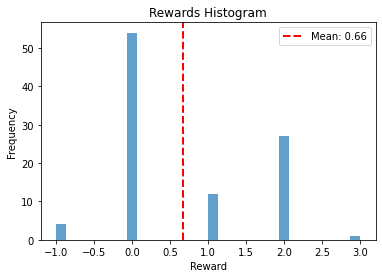

In [521]:
import matplotlib.pyplot as plt

rewards = []

for transition in agent.memory.memory:        
        rewards.append(transition[2].item())

# Step 4: Analyze the Reward Distribution
# Calculating the mean reward for each state pair
mean_rewards = np.mean(rewards)

# Plotting the histogram
plt.hist(rewards, bins=30, alpha=0.7)
plt.axvline(mean_rewards, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_rewards:.2f}")
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title("Rewards Histogram")
plt.legend()
plt.show()

## Offline Learning

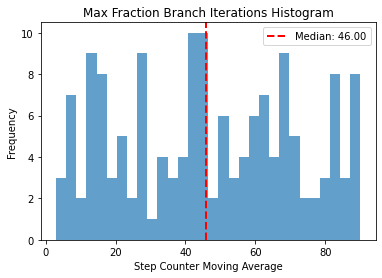

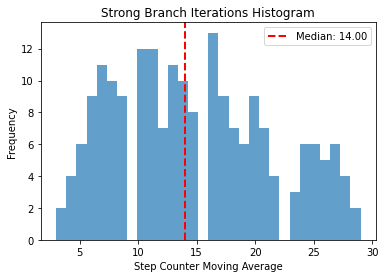

In [3]:
import pickle
import matplotlib.pyplot as plt

# Load max_frac_trees
with open('synthetic_data/trees/max_frac_trees.pkl', 'rb') as f:
    max_frac_trees = pickle.load(f)

# Load strong_branch_trees
with open('synthetic_data/trees/strong_branch_trees.pkl', 'rb') as f:
    strong_branch_trees = pickle.load(f)

def plot_histogram(trees, title):
    step_counters = [tree.step_counter for tree in trees]

    med = np.median(step_counters)

    # Plotting the histogram
    plt.hist(step_counters, bins=30, alpha=0.7)
    plt.axvline(med, color='r', linestyle='dashed', linewidth=2, label=f"Median: {med:.2f}")
    plt.xlabel('Step Counter Moving Average')
    plt.ylabel('Frequency')
    plt.title(f"{title} Iterations Histogram")
    plt.legend()
    plt.show()

# Plot moving averages for both sets of trees
plot_histogram(max_frac_trees, "Max Fraction Branch")
plot_histogram(strong_branch_trees, "Strong Branch")

In [11]:
MF_threshold = 90 
SB_threshold = 30 

max_frac_trees_filtered = [tree for tree in max_frac_trees if tree.step_counter <= MF_threshold]
strong_branch_trees_filtered = [tree for tree in strong_branch_trees if tree.step_counter <= SB_threshold]

In [15]:
print(len(max_frac_trees_filtered), len(strong_branch_trees_filtered))

405 293


In [13]:
# Save filtered max_frac_trees
with open('synthetic_data/trees/max_frac_trees.pkl', 'wb') as f:
    pickle.dump(max_frac_trees_filtered, f)

# Save filtered strong_branch_trees
with open('synthetic_data/trees/strong_branch_trees.pkl', 'wb') as f:
    pickle.dump(strong_branch_trees_filtered, f)

## Evaluating Results

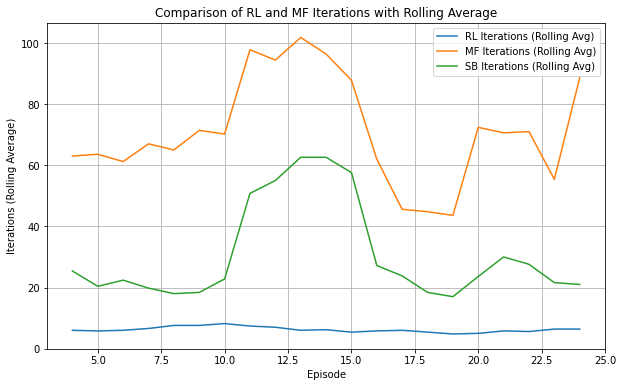

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Results CSV file
file_path = 'synthetic_data/results/results22.csv' 
df = pd.read_csv(file_path)

# Rolling averages
rolling_window_size = 5  # Adjust
df['RL_iters_rolling'] = df['RL_iters'].rolling(window=rolling_window_size).mean()
df['MF_iters_rolling'] = df['MF_iters'].rolling(window=rolling_window_size).mean()
df['SB_iters_rolling'] = df['SB_iters'].rolling(window=rolling_window_size).mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['RL_iters_rolling'], label='RL Iterations (Rolling Avg)')
plt.plot(df['MF_iters_rolling'], label='MF Iterations (Rolling Avg)')
plt.plot(df['SB_iters_rolling'], label='SB Iterations (Rolling Avg)')
plt.xlabel('Episode')
plt.ylabel('Iterations (Rolling Average)')
plt.title('Comparison of RL and MF Iterations with Rolling Average')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Results CSV file
file_path = 'synthetic_data/results/results14.csv' 
df = pd.read_csv(file_path)

# Rolling averages
rolling_window_size = 25  # Adjust
df['RL-SB_iters_rolling'] = df['RL-SB_iters'].rolling(window=rolling_window_size).mean()
df['RL-MX_iters_rolling'] = df['RL-MX_iters'].rolling(window=rolling_window_size).mean()
df['MF_iters_rolling'] = df['MF_iters'].rolling(window=rolling_window_size).mean()

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['RL-SB_iters_rolling'], label='RL-SB Iterations (Rolling Avg)')
plt.plot(df['RL-MX_iters_rolling'], label='RL-MF Iterations (Rolling Avg)')
plt.plot(df['MF_iters_rolling'], label='MF Iterations (Rolling Avg)')
plt.xlabel('Episode')
plt.ylabel('Iterations (Rolling Average)')
plt.title('Comparison of RL and MF Iterations with Rolling Average')
plt.legend()
plt.grid(True)
plt.show()

## Checking Model Outputs

In [506]:
# initialize agent
from Model import Agent
import torch

agent = Agent(34)

agent.policy_net.load_state_dict(torch.load(f"synthetic_data/models/results20.pt"))
agent.epsilon = 0.05

In [507]:
p = Tree.Problem(x,y,l0,l2, m = 1.34)
t = Tree.tree(p)
t.start_root()

False

In [508]:
node_key, j = t.max_frac_branch()
print(node_key, j)

root_node 9


In [509]:
agent.select_action(t)

('root_node', 8)

In [510]:
t.all_nodes[node_key].state

In [511]:
t.all_nodes[node_key].opt_gap

0

In [141]:
t.all_nodes[node_key].support

[2, 3, 4, 5, 6, 8]

In [142]:
for i in t.all_nodes[node_key].support:
    print(agent.policy_net(torch.tensor(np.array([t.get_state(node_key, i)]), dtype=torch.float)))

tensor([[-3.2668]], grad_fn=<AddmmBackward0>)
tensor([[-3.2611]], grad_fn=<AddmmBackward0>)
tensor([[-3.3003]], grad_fn=<AddmmBackward0>)
tensor([[-3.2818]], grad_fn=<AddmmBackward0>)
tensor([[-3.2790]], grad_fn=<AddmmBackward0>)
tensor([[-3.2997]], grad_fn=<AddmmBackward0>)


In [143]:
t.step(node_key, j)

(False, 0.721876997752983, 0.721876997752983)

## Checking Model Weights

Checking Specific Variable Importance

1. Covariance Quantile 0%
2. Covariance Quantile 25%
3. Covariance Quantile 50%
4. Covariance Quantile 75%
5. Covariance Quantile 100%
6. X dot y Quantile 0%
7. X dot y Quantile 25%
8. X dot y Quantile 50%
9. X dot y Quantile 75%
10. X dot y Quantile 100%
11. Variable Count
12. x_i Covariance 0%
13. x_i Covariance 25%
14. x_i Covariance 50%
15. x_i Covariance 75%
16. x_i Covariance 100%
17. x_i dot y
18. Steps Taken
19. Active Nodes
20. Candidate Variables
21. Lower Bound
22. Best Integer
23. Initial Gap
24. Current Gap
25. zub Length
26. zlb Length
27. Primal Value
28. Node Level
29. Support Length
30. Has Lower Bound
31. Has Upper Bound
32. Primal Beta
33. Z Value
34. Upper Z Value

In [227]:
import torch
from Model import Agent

Check_agent = Agent(34)
Check_agent.policy_net.load_state_dict(torch.load(f"synthetic_data/models/results20.pt"))

Check_agent.epsilon = 0.05

In [228]:
import os
import Tree

# Directory of problems
my_path = "synthetic_data/batch_4"
files = [f for f in os.listdir(my_path) if os.path.isfile(os.path.join(my_path,f)) and f[0]=="x"]

for f in files:
    x_file = os.path.join(my_path, f)
    y_file = os.path.join(my_path, "y"+f[1:len(f)])
    x = np.loadtxt(x_file, delimiter = ",")
    y = np.loadtxt(y_file, delimiter=",")
    l0_max = max(abs(np.dot(x.T, y)))/2.0
    l0 = l0_max*0.3
    l2 = 0
    m = 0.61
    
    # Strong Branch 
    p = Tree.Problem(x,y,l0,l2, m)
    tree = Tree.tree(p)

    # RL
    RL_iters, RL_rewards, RL_nnz, RL_og = Check_agent.RL_solve(tree,training=False)

    print(f'Iters: {RL_iters}, Reward: {RL_rewards} Memory: {len(Check_agent.memory.memory)}, \n NNZ: {RL_nnz}, Opt Gap: {RL_og}', flush=True)

Iters: 82, Reward: 54 Memory: 128, 
 NNZ: 4, Opt Gap: -0.002725379760671554
Iters: 59, Reward: 54 Memory: 246, 
 NNZ: 5, Opt Gap: -0.002895211337078897
Iters: 50, Reward: 50 Memory: 346, 
 NNZ: 5, Opt Gap: -0.0013959207682524785
Iters: 81, Reward: 55 Memory: 474, 
 NNZ: 5, Opt Gap: -0.0034987307161574153
Iters: 63, Reward: 59 Memory: 600, 
 NNZ: 5, Opt Gap: -0.0003003687716032336


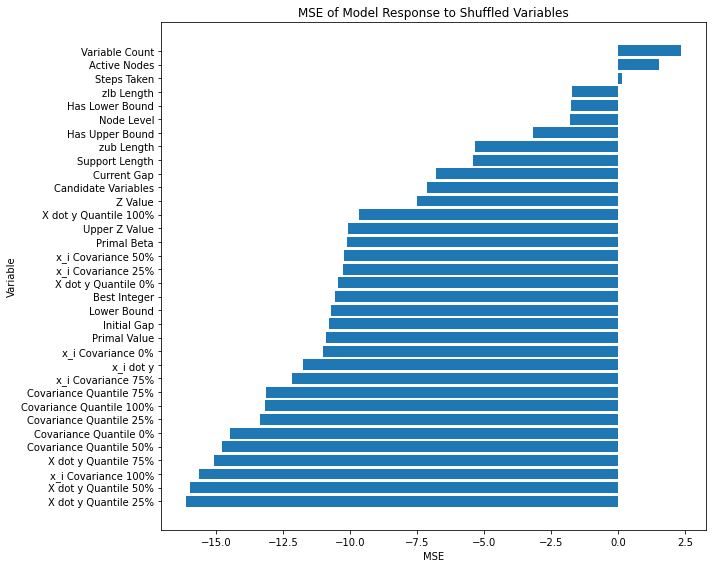

In [181]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import torch  

# Labels for each of the 34 variables
variable_labels = [
    "Covariance Quantile 0%", "Covariance Quantile 25%", "Covariance Quantile 50%",
    "Covariance Quantile 75%", "Covariance Quantile 100%", "X dot y Quantile 0%",
    "X dot y Quantile 25%", "X dot y Quantile 50%", "X dot y Quantile 75%",
    "X dot y Quantile 100%", "Variable Count", "x_i Covariance 0%",
    "x_i Covariance 25%", "x_i Covariance 50%", "x_i Covariance 75%",
    "x_i Covariance 100%", "x_i dot y", "Steps Taken", "Active Nodes",
    "Candidate Variables", "Lower Bound", "Best Integer", "Initial Gap",
    "Current Gap", "zub Length", "zlb Length", "Primal Value", "Node Level",
    "Support Length", "Has Lower Bound", "Has Upper Bound", "Primal Beta",
    "Z Value", "Upper Z Value"
]

# Each Item in memory is (prev_state, state, reward)
memory = Check_agent.memory.memory

# Extracting all states from memory
all_states = torch.cat([transition.prev_state for transition in memory])
all_true_responses = Check_agent.policy_net(all_states).detach().numpy()

variable_mse = {}

for i, variable in enumerate(variable_labels):
    shuffled_states = all_states.clone().numpy() # Copy so we can alter
    
    # Shuffle the current variable across all states
    np.random.shuffle(shuffled_states[:, i])
    
    # Convert back to tensor and get model responses for the shuffled states
    shuffled_states_tensor = torch.tensor(shuffled_states, dtype=torch.float)
    shuffled_responses = Check_agent.policy_net(shuffled_states_tensor).detach().numpy()
    
    # Calculate MSE between true responses and responses to shuffled states
    mse = mean_squared_error(all_true_responses, shuffled_responses)
    variable_mse[variable] = np.log(mse)

# Plotting
sorted_variable_mse = sorted(variable_mse.items(), key=lambda x: x[1])
variables, mses = zip(*sorted_variable_mse)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(variables, mses)  # Using barh for horizontal bars
ax.set_ylabel('Variable')
ax.set_xlabel('MSE')
ax.set_title('MSE of Model Response to Shuffled Variables')

plt.tight_layout()
plt.show()

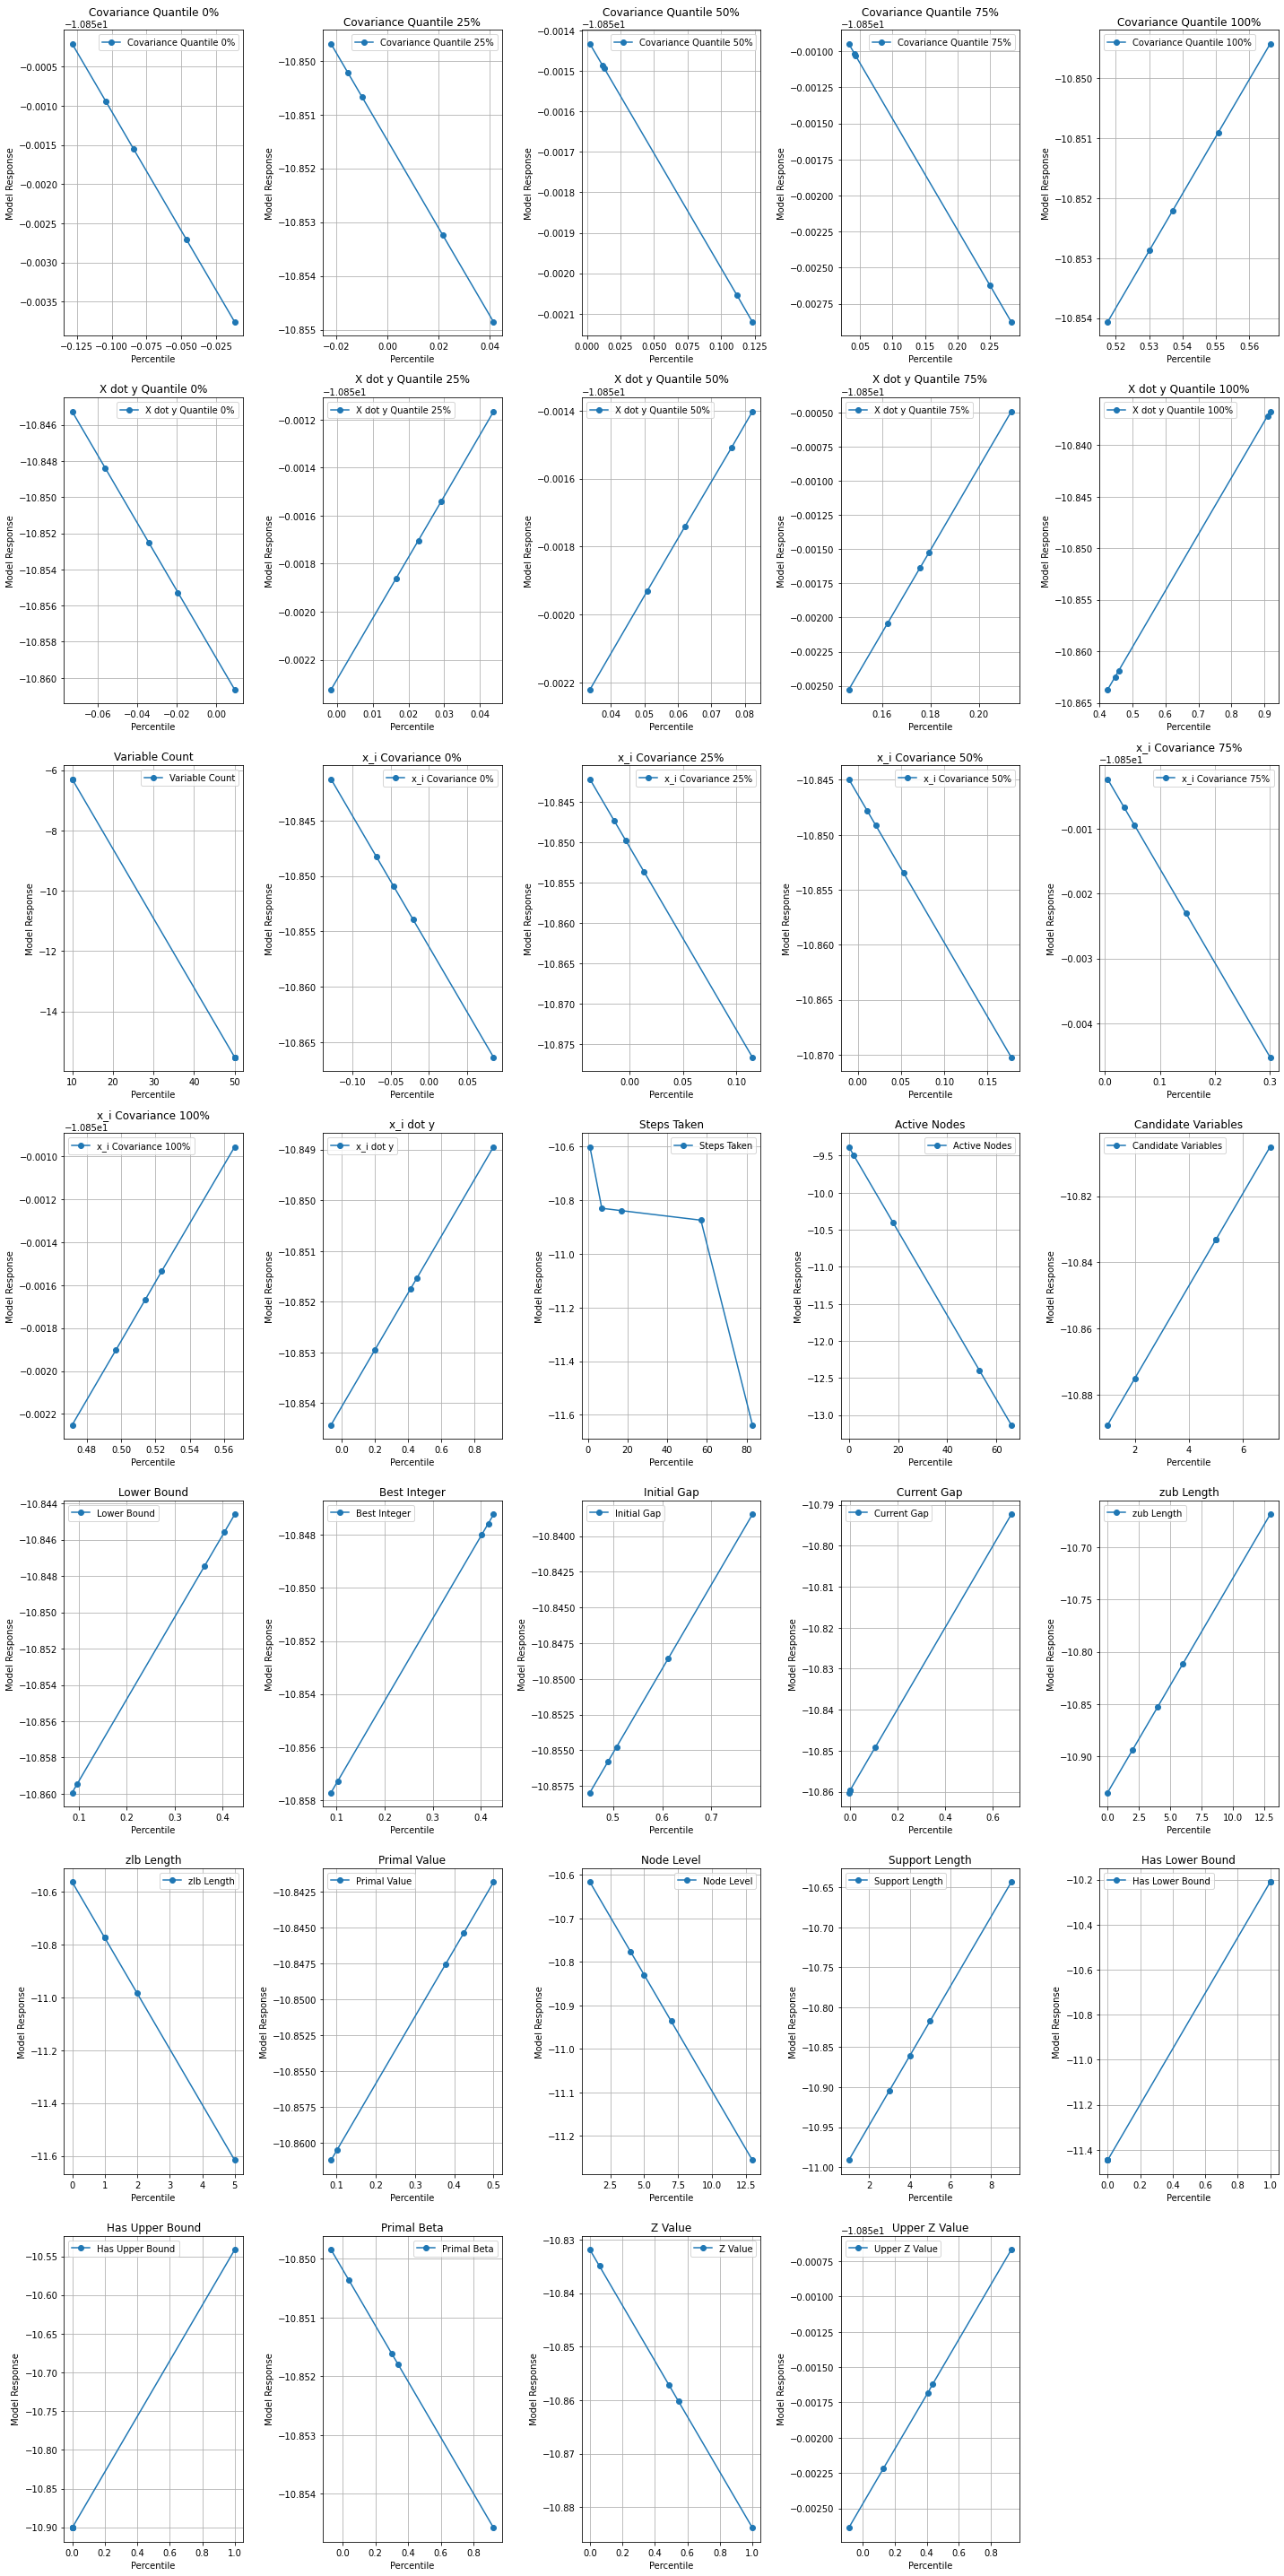

In [13]:
from collections import defaultdict
import numpy as np
import torch
import matplotlib.pyplot as plt

memory = Check_agent.memory.memory

all_states = torch.cat([transition.state for transition in memory])

percentiles = [0, 25, 50, 75, 100]
variable_percentiles = defaultdict(list)

# Labels for each of the 34 variables
variable_labels = [
    "Covariance Quantile 0%", "Covariance Quantile 25%", "Covariance Quantile 50%",
    "Covariance Quantile 75%", "Covariance Quantile 100%", "X dot y Quantile 0%",
    "X dot y Quantile 25%", "X dot y Quantile 50%", "X dot y Quantile 75%",
    "X dot y Quantile 100%", "Variable Count", "x_i Covariance 0%",
    "x_i Covariance 25%", "x_i Covariance 50%", "x_i Covariance 75%",
    "x_i Covariance 100%", "x_i dot y", "Steps Taken", "Active Nodes",
    "Candidate Variables", "Lower Bound", "Best Integer", "Initial Gap",
    "Current Gap", "zub Length", "zlb Length", "Primal Value", "Node Level",
    "Support Length", "Has Lower Bound", "Has Upper Bound", "Primal Beta",
    "Z Value", "Upper Z Value"
]

for i in range(34): 
    variable_data = all_states[:, i].numpy()
    for p in percentiles:
        percentile_value = np.percentile(variable_data, p)
        variable_percentiles[variable_labels[i]].append(percentile_value)

average_state = all_states.mean(dim=0)

# Calculate percentiles for each variable
percentiles = [0, 25, 50, 75, 100]
variable_percentiles = {label: np.percentile(all_states[:, i].numpy(), percentiles) for i, label in enumerate(variable_labels)}

responses = {variable: [] for variable in variable_labels}

# Perturb the average state with percentile values for each variable and get model response
for variable, percentiles in variable_percentiles.items():
    for value in percentiles:
        perturbed_state = average_state.clone()
        perturbed_state[variable_labels.index(variable)] = value
        
        model_response = Check_agent.policy_net(perturbed_state.unsqueeze(0)).detach().numpy()
        responses[variable].append(model_response.mean())

fig, axs = plt.subplots(len(variable_labels) // 5 + 1, 5, figsize=(20, 40))
axs = axs.flatten()

for i, (variable, resp) in enumerate(responses.items()):
    axs[i].plot(variable_percentiles[variable], resp, '-o', label=variable)
    axs[i].set_title(variable)
    axs[i].set_xlabel('Percentile')
    axs[i].set_ylabel('Model Response')
    axs[i].legend()
    axs[i].grid(True)

# Hide unused subplots
for ax in axs[i+1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()